# Imports

In [32]:
# !pip install PyMuPDF 
# !pip install transformers torch
# !pip install --upgrade ipywidgets
# !pip install -U gensim

In [67]:
import fitz  # PyMuPDF
import torch
import logging
import spacy
import os
import string
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
from sklearn.model_selection import train_test_split, LeaveOneOut, StratifiedKFold
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, MaxAbsScaler, OneHotEncoder, StandardScaler
from scipy.sparse import hstack, csr_matrix
from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModel, TFAutoModel
from collections import Counter
from gensim.models import Word2Vec

# Loading Data

In [34]:
df = pd.read_csv('pre-processed data.csv').set_index(['article_id' , 'paragraph_id'], inplace=False)
df['pos_tags'] = df['pos_tags'].apply(ast.literal_eval)
df

original_text  \
article_id paragraph_id                                                      
1          1             Provincies willen aan de slag met versoepeling...   
           2             Het draait allemaal om de drempelwaarde voor e...   
           3             Met een hogere drempelwaarde zouden minder ver...   
           4             In het hoofdlijnenakkoord hebben de vier coali...   
           5             De ondergrens is al langer onderwerp van discu...   
...                                                                    ...   
118        2             Telgenkamp vestigt haar hoop voor de korte ter...   
119        1             Waarom verzekeraars inkomsten uit zwart werk w...   
120        1             Verzekeraar wil klant helpen met zorgbemiddeli...   
           2             Verzekeraar wil wachtende patiënt aan snelle z...   
           3             Zorgbemiddeling is geen wondermiddel, maar kan...   

                                                                      text  \
article_id paragraph_id                                                      
1          1             provincie willen slag versoepeling stikstofreg...   
           2             draaien allemaal drempelwaran stikstofvergunni...   
           3             hoog drempelwaard vergunning [NEWLINE] aangevo...   
           4             hoofdlijnenakkoord vier coalitiepartij afsprek...   
           5             ondergren lang onderwerp discussie huidig Nede...   
...                                                                    ...   
118        2             telgenkamp vestigen hoop kort termijn twee cru...   
119        1             verzekeraar inkomst zwart werk vergoeden [NEWL...   
120        1             verzekeraar klant helpen zorgbemiddeling [NEWL...   
           2             verzekeraar wachten patiënt snel zorg helpen [...   
           3             zorgbemiddeling wondermiddel helpen zeggen Haa...   

                                   group  \
article_id paragraph_id                    
1          1             Bouw & Vastgoed   
           2             Bouw & Vastgoed   
           3             Bouw & Vastgoed   
           4             Bouw & Vastgoed   
           5             Bouw & Vastgoed   
...                                  ...   
118        2                        Zorg   
119        1                        Zorg   
120        1                        Zorg   
           2                        Zorg   
           3                        Zorg   

                                                 text before lemmatization  \
article_id paragraph_id                                                      
1          1             provincies willen slag versoepeling stikstofre...   
           2             draait allemaal drempelwaarde stikstofvergunni...   
           3             hogere drempelwaarde vergunningen [NEWLINE] aa...   
           4             hoofdlijnenakkoord vier coalitiepartijen afges...   
           5             ondergrens langer onderwerp discussie huidige ...   
...                                                                    ...   
118        2             telgenkamp vestigt hoop korte termijn twee cru...   
119        1             verzekeraars inkomsten zwart werk vergoeden [N...   
120        1             verzekeraar klant helpen zorgbemiddeling [NEWL...   
           2             verzekeraar wachtende patiënt snelle zorg help...   
           3             zorgbemiddeling wondermiddel helpen zegt haarl...   

                                                                  pos_tags  
article_id paragraph_id                                                     
1          1             [(provincie, NOUN), (willen, VERB), (slag, NOU...  
           2             [(draaien, VERB), (allemaal, ADV), (drempelwar...  
           3             [(hoog, ADJ), (drempelwaard, NOUN), (vergunnin...  
           4             [(hoofdlijnenakkoord, PROPN), (vi

In [35]:
for group in df['group'].unique():
    print(f"{len(df[df['group'] == group])} paragraphs in {group}.")

124 paragraphs in Bouw & Vastgoed.
114 paragraphs in Handel & Industrie.
83 paragraphs in Zakelijke Dienstverlening.
53 paragraphs in Zorg.


# POS-tags one-hot encoding & ngrams

In [ ]:
def pos_to_features(pos_tags):
    """Convert list of (word, POS) tuples into a dictionary of POS tag counts."""
    pos_counts = Counter(tag for _, tag in pos_tags)
    return dict(pos_counts)

def pos_to_ngrams(pos_tags, n=2):
    """Convert a list of POS-tag tuples into n-gram strings."""
    pos_sequence = [tag for _, tag in pos_tags]  # Extract only POS tags
    ngrams = ['_'.join(pos_sequence[i:i+n]) for i in range(len(pos_sequence)-n+1)]
    return ' '.join(ngrams)  # Convert to space-separated string for TF-IDF

In [ ]:
X = df[['text', 'pos_tags']].copy() # Testing on df

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["group"])

# Split the data into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Split the data into text and POS-tags
X_train_text, X_train_pos = X_train['text'], X_train['pos_tags']
X_val_text, X_val_pos = X_val['text'], X_val['pos_tags']
X_test_text, X_test_pos = X_test['text'], X_test['pos_tags']

# Convert text to TF-IDF representation
vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
X_train_text = vectorizer.fit_transform(X_train_text)
X_val_text = vectorizer.transform(X_val_text)
X_test_text = vectorizer.transform(X_test_text)

# Convert POS tags to feature dictionaries
X_train_pos_features = X_train_pos.apply(pos_to_features)
X_val_pos_features = X_val_pos.apply(pos_to_features)
X_test_pos_features = X_test_pos.apply(pos_to_features)

# Vectorize POS features (Fit on train, Transform on val/test)
pos_vectorizer = DictVectorizer(sparse=True)
X_train_pos = pos_vectorizer.fit_transform(X_train_pos_features)
X_val_pos = pos_vectorizer.transform(X_val_pos_features)
X_test_pos = pos_vectorizer.transform(X_test_pos_features)

# Scale POS features (Fit on train, Transform on val/test)
scaler = MaxAbsScaler()
X_train_pos = scaler.fit_transform(X_train_pos)
X_val_pos = scaler.transform(X_val_pos)
X_test_pos = scaler.transform(X_test_pos)

# Combine TF-IDF and POS tag features
X_train_combined = hstack([X_train_text, X_train_pos])
X_val_combined = hstack([X_val_text, X_val_pos])
X_test_combined = hstack([X_test_text, X_test_pos])

# Final shape check
print(f"Train shape: {X_train_combined.shape}, Validation shape: {X_val_combined.shape}, Test shape: {X_test_combined.shape}")

**Now let's test them on the data**

In [ ]:
# Tune the depth of the Random Forest using the validation set
best_depth = None
best_score = 0
depths = [5, 10, 15, 20, 25, None]  # Different depths to test

for depth in depths:
    classifier = RandomForestClassifier(max_depth=depth, random_state=42)
    classifier.fit(X_train_combined, y_train)
    val_score = classifier.score(X_val_combined, y_val)
    print(f"Depth: {depth}, Validation Score: {val_score}")
    if val_score > best_score:
        best_score = val_score
        best_depth = depth

print(f"\nBest Depth: {best_depth}, Best Validation Score: {best_score}")

# Train the final model using the best depth
final_classifier = RandomForestClassifier(max_depth=best_depth, random_state=42)
final_classifier.fit(X_train_combined, y_train)

# Test the model
y_pred = final_classifier.predict(X_test_combined)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
best_kernel = None
best_C = None
best_score = 0

# Test different kernels and values of C (Regularization parameter)
kernels = ['linear', 'rbf', 'poly']
C_values = [0.1, 1, 10]

for kernel in kernels:
    for C in C_values:
        classifier = SVC(kernel=kernel, C=C, random_state=42)
        classifier.fit(X_train_combined, y_train)
        val_score = classifier.score(X_val_combined, y_val)
        print(f"Kernel: {kernel}, C: {C}, Validation Score: {val_score}")
        if val_score > best_score:
            best_score = val_score
            best_kernel = kernel
            best_C = C

print(f"\nBest Kernel: {best_kernel}, Best C: {best_C}, Best Validation Score: {best_score}")

# Train the final model using the best kernel and C
final_classifier = SVC(kernel=best_kernel, C=best_C, random_state=42)
final_classifier.fit(X_train_combined, y_train)

# Test the model
y_pred = final_classifier.predict(X_test_combined)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
#Testing only text

best_kernel = None
best_C = None
best_score = 0

# Test different kernels and values of C (Regularization parameter)
kernels = ['linear', 'rbf', 'poly']
C_values = [0.1, 1, 10]

for kernel in kernels:
    for C in C_values:
        classifier = SVC(kernel=kernel, C=C, random_state=42)
        classifier.fit(X_train_text, y_train)
        val_score = classifier.score(X_val_text, y_val)
        print(f"Kernel: {kernel}, C: {C}, Validation Score: {val_score}")
        if val_score > best_score:
            best_score = val_score
            best_kernel = kernel
            best_C = C

print(f"\nBest Kernel: {best_kernel}, Best C: {best_C}, Best Validation Score: {best_score}")

# Train the final model using the best kernel and C
final_classifier = SVC(kernel=best_kernel, C=best_C, random_state=42)
final_classifier.fit(X_train_text, y_train)

# Test the model
y_pred = final_classifier.predict(X_test_text)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_pred))

**Now we test for pos_tag ngrams rather than one-hot encodings:**

In [ ]:
# Testing for ngrams

X = df[['text', 'pos_tags']].copy() # Testing on df

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["group"])

# Split the data into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Split the data into text and POS-tags
X_train_text, X_train_pos = X_train['text'], X_train['pos_tags']
X_val_text, X_val_pos = X_val['text'], X_val['pos_tags']
X_test_text, X_test_pos = X_test['text'], X_test['pos_tags']


# Split the data into text and POS-tags and construct ngrams
X_train_text, X_train_pos = X_train['text'], X_train['pos_tags'].apply(lambda x: pos_to_ngrams(x, n=2))
X_val_text, X_val_pos = X_val['text'], X_val['pos_tags'].apply(lambda x: pos_to_ngrams(x, n=2))
X_test_text, X_test_pos = X_test['text'], X_test['pos_tags'].apply(lambda x: pos_to_ngrams(x, n=2))



# Convert text to TF-IDF representation
vectorizer = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
X_train_text = vectorizer.fit_transform(X_train_text)
X_val_text = vectorizer.transform(X_val_text)
X_test_text = vectorizer.transform(X_test_text)

# Convert POS n-grams to TF-IDF
pos_vectorizer = TfidfVectorizer()
X_train_pos = pos_vectorizer.fit_transform(X_train_pos)
X_val_pos = pos_vectorizer.transform(X_val_pos)
X_test_pos = pos_vectorizer.transform(X_test_pos)

# Scale POS features (Fit on train, Transform on val/test)
scaler = MaxAbsScaler()
X_train_pos = scaler.fit_transform(X_train_pos)
X_val_pos = scaler.transform(X_val_pos)
X_test_pos = scaler.transform(X_test_pos)

# Combine TF-IDF and POS tag features
X_train_combined = hstack([X_train_text, X_train_pos])
X_val_combined = hstack([X_val_text, X_val_pos])
X_test_combined = hstack([X_test_text, X_test_pos])

# Final shape check
print(f"Train shape: {X_train_combined.shape}, Validation shape: {X_val_combined.shape}, Test shape: {X_test_combined.shape}")

In [ ]:
# Tune the depth of the Random Forest using the validation set
best_depth = None
best_score = 0
depths = [5, 10, 15, 20, 25, None]  # Different depths to test

for depth in depths:
    classifier = RandomForestClassifier(max_depth=depth, random_state=42)
    classifier.fit(X_train_combined, y_train)
    val_score = classifier.score(X_val_combined, y_val)
    print(f"Depth: {depth}, Validation Score: {val_score}")
    if val_score > best_score:
        best_score = val_score
        best_depth = depth

print(f"\nBest Depth: {best_depth}, Best Validation Score: {best_score}")

# Train the final model using the best depth
final_classifier = RandomForestClassifier(max_depth=best_depth, random_state=42)
final_classifier.fit(X_train_combined, y_train)

# Test the model
y_pred = final_classifier.predict(X_test_combined)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
best_kernel = None
best_C = None
best_score = 0

# Test different kernels and values of C (Regularization parameter)
kernels = ['linear', 'rbf', 'poly']
C_values = [0.1, 1, 10]

for kernel in kernels:
    for C in C_values:
        classifier = SVC(kernel=kernel, C=C, random_state=42)
        classifier.fit(X_train_combined, y_train)
        val_score = classifier.score(X_val_combined, y_val)
        print(f"Kernel: {kernel}, C: {C}, Validation Score: {val_score}")
        if val_score > best_score:
            best_score = val_score
            best_kernel = kernel
            best_C = C

print(f"\nBest Kernel: {best_kernel}, Best C: {best_C}, Best Validation Score: {best_score}")

# Train the final model using the best kernel and C
final_classifier = SVC(kernel=best_kernel, C=best_C, random_state=42)
final_classifier.fit(X_train_combined, y_train)

# Test the model
y_pred = final_classifier.predict(X_test_combined)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
#Testing only text

best_kernel = None
best_C = None
best_score = 0

# Test different kernels and values of C (Regularization parameter)
kernels = ['linear', 'rbf', 'poly']
C_values = [0.1, 1, 10]

for kernel in kernels:
    for C in C_values:
        classifier = SVC(kernel=kernel, C=C, random_state=42)
        classifier.fit(X_train_text, y_train)
        val_score = classifier.score(X_val_text, y_val)
        print(f"Kernel: {kernel}, C: {C}, Validation Score: {val_score}")
        if val_score > best_score:
            best_score = val_score
            best_kernel = kernel
            best_C = C

print(f"\nBest Kernel: {best_kernel}, Best C: {best_C}, Best Validation Score: {best_score}")

# Train the final model using the best kernel and C
final_classifier = SVC(kernel=best_kernel, C=best_C, random_state=42)
final_classifier.fit(X_train_text, y_train)

# Test the model
y_pred = final_classifier.predict(X_test_text)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nTest Classification Report:\n", classification_report(y_test, y_pred))

# Overarching Function

**The function evaluate_model() as described below is an overarching function for finding the model with the highest validation accuracy given the provided parameter values.** <br>

Expected parameter values: <br>
- **df**: Pandas DataFrame containing the following columns:
> **original_text**: Text before any pre-processing steps were taken, $str$ <br>
> **text before lemmatization**: Text just before lemmatization has taken place, $str$ <br>
> **text**: Text after all pre-processing steps have been completed, $str$ <br>
> **pos_tags**: Part-Of-Speech tags, $list$ <br>
> **group**: Target variable, $str$ (Converted to numeric in the evaluate_model function) <br>
- **test_ratio**: The ratio of the data that is reserved for testing. Any floating point in the inclusive interval [0, 1].
> Note that in the case of hold-out cross-validation (which is performed when $k=1$), test_ratio is also used the ratio of training data that is reserved for validation.
- **k_values**: List of k values for k-fold cross-validation. Default value: [2, 3, 5, 10, 20]
- **model_type**: Selects the type of classifier from amongst the following: ["svm", "naive_bayes", "random_forest"].
> If model_type="naive_bayes", a multinomial naive bayes classifier is trained if $pos=$"none" and embedding $\in$ ["BoW", "tf-idf"]. Otherwise, a Gaussian naive bayes classifier is trained since the resulting word embedding will contain continuous features, which multinomial naive bayes classifiers cannot handle.
- **embedding**: Selects the type of word embedding from amongst the following: ["BoW", "tf-idf", "BERTje", "mBERT", "RobBERT", "Word2Vec"].
- **pos**: Selects how POS tags are used from amongst the following: ["none", "one-hot", "ngram"].
- **ngram_size**: Selects the type of ngrams that are used. Must be an integer, no smaller than 2. Set to 2 by default.
> Note that if _pos_$\neq$"ngram", n is not used and the value of ngram_size is irrelevant.
- **print_updates**: If set to True, intermediate and final results will be printed in addition to being returned. Default value: True
- **show_class_accuracy**: If set to True, the accuracies per class are shown for the final classifier. Default: True
- **show_confusion_matrix**: If set to True, the resulting confusion matrix of the final classifier will be shown. Default: True

**The parameters below are model-specific and their values are only relevant if the corresponding model type is selected.**

- **C_values**: A list containing all values of C to be tested for SVM classifiers. Default value: [0.1, 1, 10]
- **kernel_values**: A list containing all kernel types to be tested for SVM classifiers. Default value: ['linear', 'rbf', 'poly']
- **max_depth_values**: A list containing all maximum depth values to be tested for Random Forest classifiers. Default value: [5, 10, 15, 20, None]
- **alpha_values**: A list containing all $\alpha$ values to be tested for multinomial naive bayes classifiers. Default value: [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
- **fit_prior_values**: A list containing all prior_values values to be tested for Multinomial Naive Bayes classifiers. Default value: [True, False]
- **var_smoothing_values**: A list containing all var_smoothing values to be tested for Gaussian Naive Bayes classifiers. Default value: [$10^{-11}$, $10^{-10}$, $10^{-9}$, $10^{-8}$, $10^{-7}$]

In [56]:
def evaluate_model(df: pd.DataFrame, test_ratio: float = 0.15, k_values: list = [2, 3, 5, 10, 20], 
                   model_type: str = "svm", embedding: str = "tf-idf",
                   pos: str = "none", ngram_size: int = 2, print_updates: bool = True,
                   show_class_accuracy: bool = True, show_confusion_matrix: bool = True,
                   C_values: list = [0.1, 1, 10], kernel_values: list = ['linear', 'rbf', 'poly'],
                   max_depth_values: list = [5, 10, 15, 20, None],
                   alpha_values: list = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values: list = [True, False],
                   var_smoothing_values: list = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7]):
    """
    Function to extract embeddings (TF-IDF or BERTje), perform classification with SVM hyperparameter tuning, and evaluate using k-fold cross-validation.

    For parameters, see the markdown above this cell.

    Returns:
        dict: Dictionary of accuracies for each k and best SVM hyperparameters.
    """
    
    #Raise appropriate error message in case of a faulty parameter value
    if not isinstance(df, pd.DataFrame):
        raise ValueError(f"Invalid input data. Please ensure df is a Pandas DataFrame")
    if test_ratio <= 0 or test_ratio >= 1:
        raise ValueError(f"Invalid test_ratio. Choose a value in the exclusive interval (0,1)")
    if not all(isinstance(x, int) and x > 0 for x in k_values):
        raise ValueError(f"Invalid k_values. Please ensure all entries in k_values are positive integers")
    if model_type.lower() not in ["svm", "naive_bayes", "random_forest"]:
        raise ValueError(f"Invalid model_type. Choose from {'SVM', 'Naive_Bayes', 'Random_Forest'}")
    if embedding.lower() not in ["bow", "tf-idf", "bertje", "mbert", "robbert", "word2vec"]:
        raise ValueError(f'Invalid embedding. Choose from ["BoW", "tf-idf", "BERTje", "mBERT", "RobBERT", "Word2Vec"]')
    if pos not in ["none", "one-hot", "ngram"]:
        raise ValueError(f'Invalid pos. Choose from ["none", "one-hot", "ngram"]')
    if type(ngram_size) != int or ngram_size < 2:
        raise ValueError(f'Invalid ngram_size. Please ensure that ngram_size is an integer, no smaller than 2')
    if not type(print_updates) == bool:
        raise ValueError(f'Invalid print_updates value. Please ensure this parameter has a boolean value.')
    if not all(x > 0 for x in C_values):
        raise ValueError(f'Invalid C_values. Please ensure that all entries in C_values lie in the exclusive interval (0, inf)')
    if not all(type(x) == str for x in kernel_values):
        raise ValueError(f'Invalid kernel_values. Please ensure every entry in kernel_values is a string that represents a kernel type')
    if not all((type(x) == int and x > 0) or x == None for x in max_depth_values):
        raise ValueError(f'Invalid max_depth_values. Please ensure every entry in max_depth_values is a positive integer or None for no maximum')
    if not all((type(x) == int or type(x) == float) and (x > 0) for x in alpha_values):
        raise ValueError(f'Invalid alpha_values. Please ensure every entry in alpha_values is numeric and non-negative')
    if not all(type(x) == bool for x in fit_prior_values):
        raise ValueError(f'Invalid fit_prior_values. Please ensure every entry in fit_prior_values is boolean')
    if not all(x >= 0 for x in var_smoothing_values):
        raise ValueError(f'Invalid var_smoothing_values. Please ensure every entry in var_smoothing_values is a non-negative number')
        

    # Convert labels to numeric format
    df["label"] = df["group"].astype("category").cat.codes 
    df_train, df_test = train_test_split(df, test_size=test_ratio, stratify=df["label"], random_state=42)
    
    # ===========================
    # 1. Extract Features (BoW, TF-IDF, BERTje, mBERT, RobBERT or Word2Vec)
    # ===========================

    if embedding.lower() == "bow":
        if print_updates:
            print("\nUsing Bag of Words (BoW) Embeddings...")
        vectorizer = CountVectorizer(max_features=10_000)
        embeddings = vectorizer.fit_transform(df_train["text"])#.toarray()
        test_embeddings = vectorizer.transform(df_test["text"])#.toarray()
    
    elif embedding.lower() == "tf-idf":
        if print_updates:
            print("\nUsing TF-IDF Embeddings...")
        vectorizer = TfidfVectorizer(max_features=10_000)
        embeddings = vectorizer.fit_transform(df_train["text"])#.toarray()
        test_embeddings = vectorizer.transform(df_test["text"])

    elif embedding.lower() in ["bertje", "mbert", "robbert"]:
        if embedding.lower() == "bertje":
            model_name = "GroNLP/bert-base-dutch-cased"
        elif embedding.lower() == "mbert":
            model_name = "bert-base-multilingual-cased"
        elif embedding.lower() == "robbert":
            model_name = "pdelobelle/robbert-v2-dutch-base"

        if print_updates:
            print(f"\nUsing {embedding.upper()} Embeddings ({model_name})...")

        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name)
        model.eval()

        def get_word_embedding(text):
            with torch.no_grad():
                tokens = tokenizer(text, padding="max_length", truncation=True, max_length=256, return_tensors="pt")
                output = model(**tokens)
                embeddings = output.last_hidden_state.mean(dim=1)
            return embeddings.squeeze().numpy()

        if print_updates:
            print(f"\nCreating {embedding} embedding, this may take a few minutes.")
        embeddings = np.array([get_word_embedding(text) for text in df_train["text"]])
        test_embeddings = np.array([get_word_embedding(text) for text in df_test["text"]])

    elif embedding.lower() == "word2vec":
        if print_updates:
            print("\nUsing Word2Vec Embeddings...")

        sentences = [text.split() for text in df_train["text"]]
        w2v_model = Word2Vec(sentences, vector_size=300, window=5, min_count=2, workers=4)

        def get_w2v_embedding(text):
            words = text.split()
            word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
            return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(300)

        embeddings = np.array([get_w2v_embedding(text) for text in df_train["text"]])
        test_embeddings = np.array([get_w2v_embedding(text) for text in df_test["text"]])

    else:
        raise ValueError("Invalid embedding type. Choose 'tf-idf' 'BERTje', 'mBERT', 'RobBERT' or 'Word2Vec'.")

    # ===========================
    # 2. Process POS Tags if Needed
    # ===========================

    if pos == "one-hot":
        if print_updates:
            print("\nUsing One-Hot Encoding for POS Tags...")

        def pos_to_features(pos_tags):
            """Convert list of (word, POS) tuples into a dictionary of POS tag counts."""
            pos_counts = Counter(tag for _, tag in pos_tags)
            return dict(pos_counts)

        # Convert to list of dictionaries
        pos_features = [pos_to_features(tags) for tags in df_train["pos_tags"]]
        test_pos_features = [pos_to_features(tags) for tags in df_test["pos_tags"]]
    
        # Convert list of dictionaries to Pandas DataFrame (fill missing tags with 0)
        pos_df = pd.DataFrame(pos_features).fillna(0)
        pos_df_test = pd.DataFrame(test_pos_features).fillna(0)

        # Ensure that pos_df_test and pos_df_test have the same columns
        pos_df_test = pos_df_test.reindex(columns=pos_df.columns, fill_value=0)
    
        # Create OneHotEncoder and use it on the pos features
        encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")
        pos_features_encoded = encoder.fit_transform(pos_df)
        pos_features_encoded_test = encoder.transform(pos_df_test)
    
        # Scale the POS features
        scaler = StandardScaler()
        pos_features_scaled = scaler.fit_transform(pos_features_encoded)
        pos_features_scaled_test = scaler.transform(pos_features_encoded_test)

        # Ensure embeddings and pos_features_scaled have the same format
        if isinstance(embeddings, np.ndarray):  
            embeddings = csr_matrix(embeddings)  # Convert dense to sparse
        if isinstance(test_embeddings, np.ndarray):  
            test_embeddings = csr_matrix(test_embeddings)  # Convert dense to sparse

        if not isinstance(pos_features_scaled, csr_matrix):  
            pos_features_scaled = csr_matrix(pos_features_scaled)  # Convert dense to sparse
        if not isinstance(pos_features_scaled_test, csr_matrix):  
            pos_features_scaled_test = csr_matrix(pos_features_scaled_test)  # Convert dense to sparse

        # Combine embeddings with POS features
        embeddings = hstack([embeddings, pos_features_scaled])
        test_embeddings = hstack([test_embeddings, pos_features_scaled_test])

    elif pos.lower() == "ngram":
        if print_updates:
            print(f"\nUsing N-gram POS Features (n={ngram_size})...")
        
        # Function to convert POS tags to n-grams
        def pos_to_ngrams(pos_tags, n=2):
            """Convert a list of POS-tag tuples into n-gram strings."""
            pos_sequence = [tag for _, tag in pos_tags]  # Extract only POS tags
            ngrams = ['_'.join(pos_sequence[i:i+n]) for i in range(len(pos_sequence)-n+1)]
            return ' '.join(ngrams)  # Convert to space-separated string for TF-IDF

        # Create POS n-grams
        pos_ngrams = np.array([pos_to_ngrams(tags, ngram_size) for tags in df_train["pos_tags"]])
        pos_ngrams_test = np.array([pos_to_ngrams(tags, ngram_size) for tags in df_test["pos_tags"]])

        # Use TF-IDF to extract n-gram features
        vectorizer = TfidfVectorizer(max_features=1000)  # Use fewer features since it's for POS
        pos_embeddings = vectorizer.fit_transform(pos_ngrams)#.toarray()
        pos_embeddings_test = vectorizer.transform(pos_ngrams_test)

        # Ensure embeddings and pos_features_scaled have the same format
        if isinstance(embeddings, np.ndarray):  
            embeddings = csr_matrix(embeddings)  # Convert dense to sparse
        if isinstance(test_embeddings, np.ndarray):  
            test_embeddings = csr_matrix(test_embeddings)  # Convert dense to sparse

        if not isinstance(pos_embeddings, csr_matrix):  
            pos_embeddings = csr_matrix(pos_embeddings)  # Convert dense to sparse
        if not isinstance(pos_embeddings_test, csr_matrix):  
            pos_embeddings_test = csr_matrix(pos_embeddings_test)  # Convert dense to sparse
        
        # Combine embeddings with POS n-grams features
        embeddings = hstack([embeddings, pos_embeddings])
        test_embeddings = hstack([test_embeddings, pos_embeddings_test])

    elif pos != "none":
        raise ValueError("Invalid POS type. Choose 'none', 'one-hot', or 'ngram'.")

    # ===========================
    # 3. Model Evaluation (Holdout or k-Fold) with Hyperparameter Search
    # ===========================

    # Set initial performance metrics such that they can be updated after a better classifier has been found
    best_k = None
    best_accuracy = 0
    best_params = None
    results = {}

    # For every value of k, we find the best parameter settings and save them in the results dictionary
    for k in k_values:
        accuracy_scores = []
        best_model_params = {}

        if k == 1: # Use regular hold-out cross-validation
            X_train, X_val, y_train, y_val = train_test_split(
                embeddings, df_train["label"], test_size=test_ratio, stratify=df_train["label"], random_state=42
            )
            
            if model_type.lower() == "svm":
                for C in C_values:
                    for kernel in kernel_values:
                        classifier = SVC(kernel=kernel, C=C)
                        classifier.fit(X_train, y_train)
                        accuracy = accuracy_score(y_val, classifier.predict(X_val))
                        if accuracy > best_accuracy:
                            best_accuracy, best_model_params = accuracy, {"C": C, "kernel": kernel}
            
            elif model_type.lower() == "random_forest":
                for max_depth in max_depth_values:
                    classifier = RandomForestClassifier(max_depth=max_depth, random_state=42)
                    classifier.fit(X_train, y_train)
                    accuracy = accuracy_score(y_val, classifier.predict(X_val))
                    if accuracy > best_accuracy:
                        best_accuracy, best_model_params = accuracy, {"max_depth": max_depth}
            
            elif model_type.lower() == "naive_bayes":
                if pos == "none" and embedding.lower() in ["bow", "tf-idf"]: # In this case all features are discrete, so we can use MultinomialNB
                    for alpha in alpha_values:
                        for fit_prior in fit_prior_values:
                            classifier = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
                            classifier.fit(X_train, y_train)
                            accuracy = accuracy_score(y_val, classifier.predict(X_val))
                            if accuracy > best_accuracy:
                                best_accuracy, best_model_params = accuracy, {"alpha": alpha, "fit_prior": fit_prior}
                else: # In this case, there are continuous features, so we use GaussianNB
                    for var_smoothing in var_smoothing_values:
                        classifier = GaussianNB(var_smoothing=var_smoothing)
                        classifier.fit(X_train.toarray(), y_train)  # Convert sparse to dense for GaussianNB
                        accuracy = accuracy_score(y_val, classifier.predict(X_val.toarray()))
                        if accuracy > best_accuracy:
                            best_accuracy, best_model_params = accuracy, {"var_smoothing": var_smoothing}

            else:
                raise ValueError('Invalid model_type. Choose "svm", "random_forest" or "naive_bayes".')

            accuracy_scores.append(best_accuracy)
            
        else:  # Use stratified k-fold cross-validation
            kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
            for train_index, val_index in kf.split(embeddings, df_train["label"]):
                X_train, X_val = embeddings[train_index], embeddings[val_index]
                y_train, y_val = df_train["label"].iloc[train_index].values, df_train["label"].iloc[val_index].values
                
                best_fold_accuracy = 0
                
                if model_type == "svm":
                    for C in C_values:
                        for kernel in kernel_values:
                            classifier = SVC(kernel=kernel, C=C)
                            classifier.fit(X_train, y_train)
                            accuracy = accuracy_score(y_val, classifier.predict(X_val))
                            if accuracy > best_fold_accuracy:
                                best_fold_accuracy, best_model_params = accuracy, {"C": C, "kernel": kernel}
                
                elif model_type == "random_forest":
                    for max_depth in max_depth_values:
                        classifier = RandomForestClassifier(max_depth=max_depth, random_state=42)
                        classifier.fit(X_train, y_train)
                        accuracy = accuracy_score(y_val, classifier.predict(X_val))
                        if accuracy > best_fold_accuracy:
                            best_fold_accuracy, best_model_params = accuracy, {"max_depth": max_depth}
                
                elif model_type == "naive_bayes":
                    if pos == "none" and embedding.lower() in ["bow", "tf-idf"]:
                        for alpha in alpha_values:
                            for fit_prior in fit_prior_values:
                                classifier = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
                                classifier.fit(X_train, y_train)
                                accuracy = accuracy_score(y_val, classifier.predict(X_val))
                                if accuracy > best_fold_accuracy:
                                    best_fold_accuracy, best_model_params = accuracy, {"alpha": alpha, "fit_prior": fit_prior}
                    else:
                        for var_smoothing in var_smoothing_values:
                            classifier = GaussianNB(var_smoothing=var_smoothing)
                            classifier.fit(X_train.toarray(), y_train)
                            accuracy = accuracy_score(y_val, classifier.predict(X_val.toarray()))
                            if accuracy > best_fold_accuracy:
                                best_fold_accuracy, best_model_params = accuracy, {"var_smoothing": var_smoothing}
                                
                else:
                    raise ValueError('Invalid model_type. Choose "svm", "random_forest" or "naive_bayes".')
                
                accuracy_scores.append(best_fold_accuracy)
        
        results[k] = {"accuracy": np.mean(accuracy_scores), "best_params": best_model_params}
        
        if print_updates:
            print(f"Best {model_type} Params for k={k}: {results[k]['best_params']}, Mean Validation Accuracy: {results[k]['accuracy']:.4f}")

        if results[k]["accuracy"] > best_accuracy:
            best_k = k
            best_accuracy = results[k]["accuracy"]
            best_params = best_model_params
            best_model = classifier

    # Evaluate best model on test set
    if not isinstance(test_embeddings, np.ndarray):
        test_accuracy = accuracy_score(df_test["label"], best_model.predict(test_embeddings.toarray()))
    else:
        test_accuracy = accuracy_score(df_test["label"], best_model.predict(test_embeddings))
    if print_updates:
        print(f"\nBest model found: \nModel={model_type}, \nParameter values: {results[best_k]['best_params']}, \nValidation Accuracy: {results[best_k]['accuracy']}")
        print(f"Final Test Accuracy: {test_accuracy:.4f}")

    if show_class_accuracy:
        y_test = df_test["label"]
        
        if not isinstance(test_embeddings, np.ndarray):
            y_pred = best_model.predict(test_embeddings.toarray())
        else:
            y_pred = best_model.predict(test_embeddings)
            
        cm = confusion_matrix(y_test, y_pred)
        
        # Class names (assuming they are in the same order as in y_train or y_test)
        class_names = np.unique(y_test)  # This will give you the unique class labels
        
        # Calculate per-class accuracy: TP / (TP + FN)
        class_accuracies = cm.diagonal() / cm.sum(axis=1)
        
        # Print the accuracy for each class along with its name
        for i, acc in enumerate(class_accuracies):
            print(f"Class '{class_names[i]}' Accuracy: {acc:.4f}")

    if show_confusion_matrix:
        y_test = df_test["label"]
        
        if not isinstance(test_embeddings, np.ndarray):
            y_pred = best_model.predict(test_embeddings.toarray())
        else:
            y_pred = best_model.predict(test_embeddings)
            
        cm = confusion_matrix(y_test, y_pred)
        class_mapping = {0: 'Bouw & Vastgoed', 1: 'Handel & Industrie', 2: 'Zakelijke Dienstverlening', 3: 'Zorg'}
        class_names = [class_mapping[i] for i in np.unique(y_test)]
        
        # Plotting the confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=True)
        
        # Label the axes
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        
        # Display the plot
        plt.show()
    
    return results

# Testing:


Using TF-IDF Embeddings...
Best random_forest Params for k=2: {'max_depth': None}, Mean Validation Accuracy: 0.5015
Best random_forest Params for k=3: {'max_depth': 10}, Mean Validation Accuracy: 0.5299
Best random_forest Params for k=5: {'max_depth': 5}, Mean Validation Accuracy: 0.5331

Best model found: 
Model=random_forest, 
Parameter values: {'max_depth': 5}, 
Validation Accuracy: 0.5330853174603175
Final Test Accuracy: 0.6316
Class '0' Accuracy: 0.8947
Class '1' Accuracy: 0.7059
Class '2' Accuracy: 0.2308
Class '3' Accuracy: 0.5000


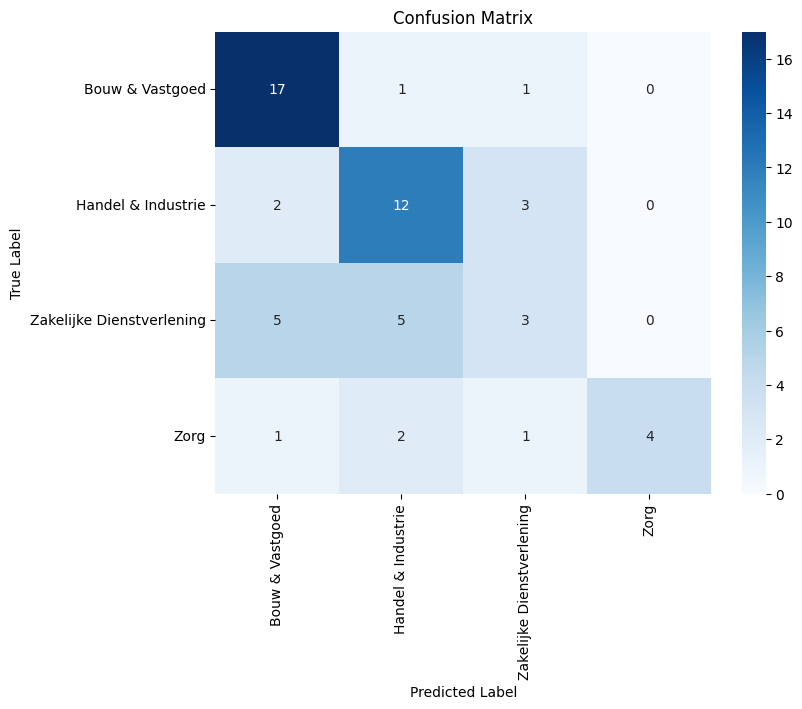

{2: {'accuracy': 0.5015325212960752, 'best_params': {'max_depth': None}},
 3: {'accuracy': 0.5298592392932016, 'best_params': {'max_depth': 10}},
 5: {'accuracy': 0.5330853174603175, 'best_params': {'max_depth': 5}}}

In [46]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "tf-idf", model_type = "random_forest",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "none", ngram_size = 2,)


Using BERTJE Embeddings (GroNLP/bert-base-dutch-cased)...


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Creating BERTje embedding, this may take a few minutes.
Best random_forest Params for k=2: {'max_depth': 5}, Mean Validation Accuracy: 0.5741
Best random_forest Params for k=3: {'max_depth': 10}, Mean Validation Accuracy: 0.5991
Best random_forest Params for k=5: {'max_depth': 10}, Mean Validation Accuracy: 0.5928

Best model found: 
Model=random_forest, 
Parameter values: {'max_depth': 10}, 
Validation Accuracy: 0.5991015274034142
Final Test Accuracy: 0.5439
Class '0' Accuracy: 0.6316
Class '1' Accuracy: 0.5882
Class '2' Accuracy: 0.3846
Class '3' Accuracy: 0.5000


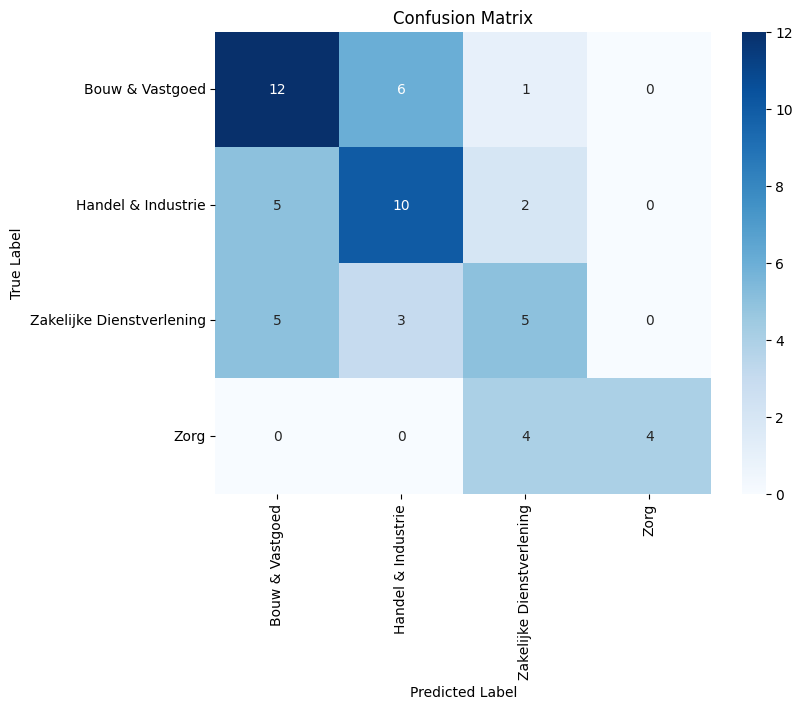

{2: {'accuracy': 0.5740983998089324, 'best_params': {'max_depth': 5}},
 3: {'accuracy': 0.5991015274034142, 'best_params': {'max_depth': 10}},
 5: {'accuracy': 0.5928075396825397, 'best_params': {'max_depth': 10}}}

In [47]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "BERTje", model_type = "random_forest",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "none", ngram_size = 2)


Using TF-IDF Embeddings...

Using One-Hot Encoding for POS Tags...


C:\Users\20193204\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Best random_forest Params for k=2: {'max_depth': 20}, Mean Validation Accuracy: 0.5016
Best random_forest Params for k=3: {'max_depth': 5}, Mean Validation Accuracy: 0.5392
Best random_forest Params for k=5: {'max_depth': 20}, Mean Validation Accuracy: 0.5709

Best model found: 
Model=random_forest, 
Parameter values: {'max_depth': 20}, 
Validation Accuracy: 0.5709325396825398
Final Test Accuracy: 0.6140
Class '0' Accuracy: 0.7895
Class '1' Accuracy: 0.6471
Class '2' Accuracy: 0.2308
Class '3' Accuracy: 0.7500


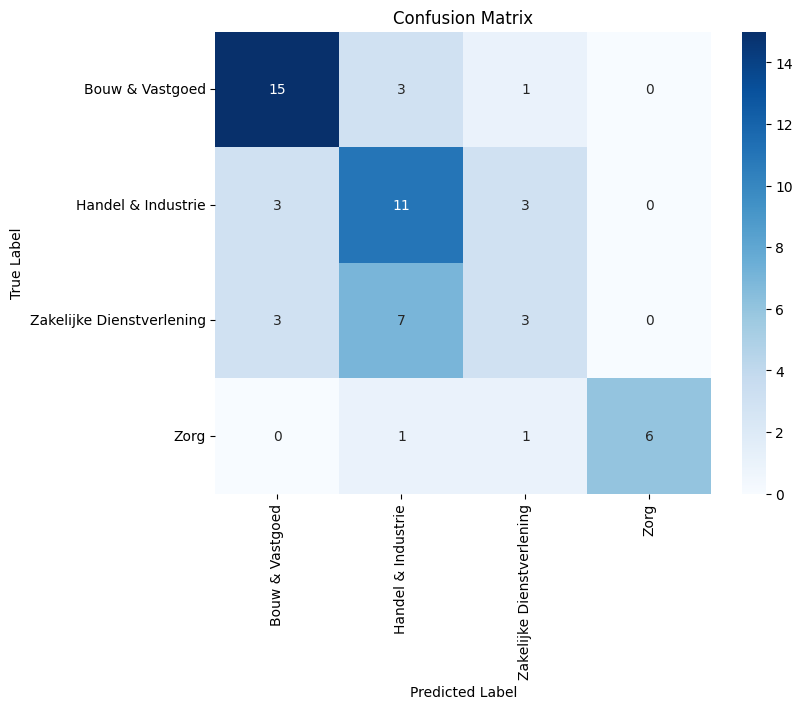

{2: {'accuracy': 0.5015723270440251, 'best_params': {'max_depth': 20}},
 3: {'accuracy': 0.5391734052111411, 'best_params': {'max_depth': 5}},
 5: {'accuracy': 0.5709325396825398, 'best_params': {'max_depth': 20}}}

In [48]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "tf-idf", model_type = "random_forest",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "one-hot", ngram_size = 2)


Using MBERT Embeddings (bert-base-multilingual-cased)...

Creating mbert embedding, this may take a few minutes.

Using N-gram POS Features (n=2)...
Best random_forest Params for k=2: {'max_depth': 15}, Mean Validation Accuracy: 0.5298
Best random_forest Params for k=3: {'max_depth': 15}, Mean Validation Accuracy: 0.5677
Best random_forest Params for k=5: {'max_depth': 5}, Mean Validation Accuracy: 0.5642

Best model found: 
Model=random_forest, 
Parameter values: {'max_depth': 15}, 
Validation Accuracy: 0.5676849356094639
Final Test Accuracy: 0.5439
Class '0' Accuracy: 0.5789
Class '1' Accuracy: 0.7059
Class '2' Accuracy: 0.3077
Class '3' Accuracy: 0.5000


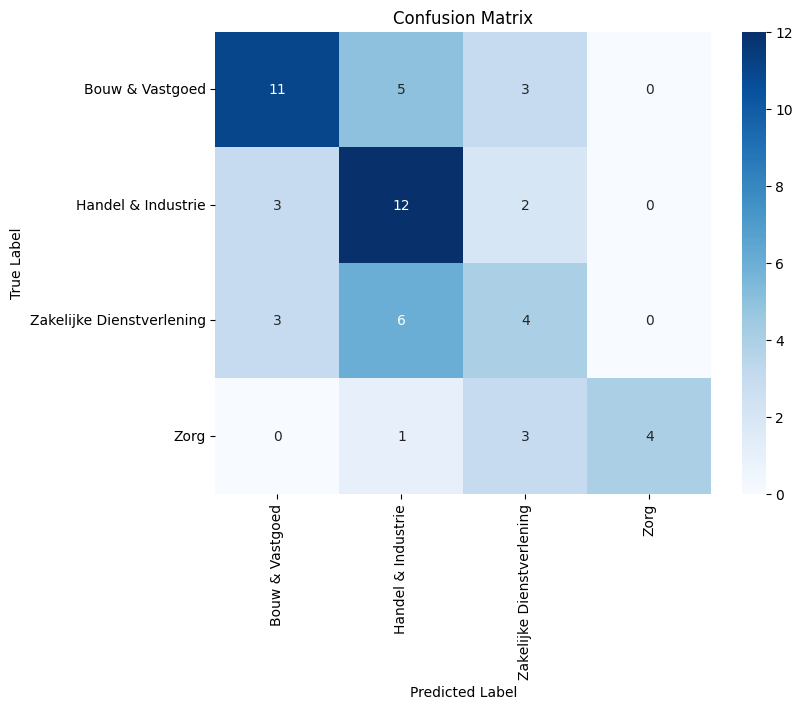

{2: {'accuracy': 0.529794602340578, 'best_params': {'max_depth': 15}},
 3: {'accuracy': 0.5676849356094639, 'best_params': {'max_depth': 15}},
 5: {'accuracy': 0.5641865079365079, 'best_params': {'max_depth': 5}}}

In [49]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "mbert", model_type = "random_forest",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "ngram", ngram_size = 2)


Using BERTJE Embeddings (GroNLP/bert-base-dutch-cased)...


Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Creating BERTje embedding, this may take a few minutes.
Best svm Params for k=2: {'C': 0.1, 'kernel': 'linear'}, Mean Validation Accuracy: 0.6750
Best svm Params for k=3: {'C': 10, 'kernel': 'rbf'}, Mean Validation Accuracy: 0.7095
Best svm Params for k=5: {'C': 10, 'kernel': 'rbf'}, Mean Validation Accuracy: 0.6970

Best model found: 
Model=svm, 
Parameter values: {'C': 10, 'kernel': 'rbf'}, 
Validation Accuracy: 0.7094938604372567
Final Test Accuracy: 0.7368
Class '0' Accuracy: 0.7895
Class '1' Accuracy: 0.8235
Class '2' Accuracy: 0.5385
Class '3' Accuracy: 0.7500


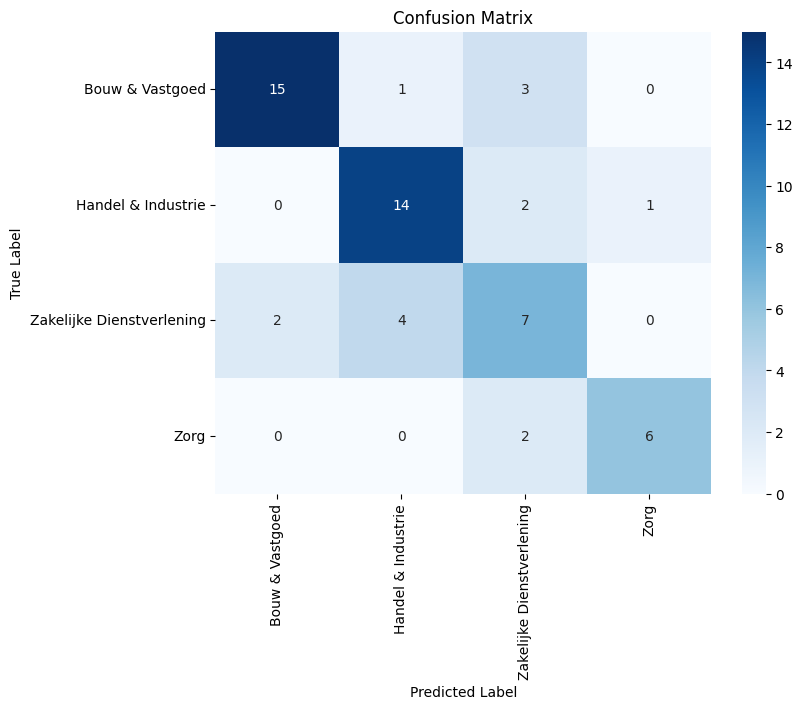

{2: {'accuracy': 0.6749860679882175,
  'best_params': {'C': 0.1, 'kernel': 'linear'}},
 3: {'accuracy': 0.7094938604372567,
  'best_params': {'C': 10, 'kernel': 'rbf'}},
 5: {'accuracy': 0.6969742063492064,
  'best_params': {'C': 10, 'kernel': 'rbf'}}}

In [50]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "BERTje", model_type = "svm",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "none", ngram_size = 2)


Using Bag of Words (BoW) Embeddings...

Using One-Hot Encoding for POS Tags...


C:\Users\20193204\AppData\Roaming\Python\Python310\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Best svm Params for k=2: {'C': 1, 'kernel': 'rbf'}, Mean Validation Accuracy: 0.5109
Best svm Params for k=3: {'C': 10, 'kernel': 'rbf'}, Mean Validation Accuracy: 0.5172
Best svm Params for k=5: {'C': 0.1, 'kernel': 'linear'}, Mean Validation Accuracy: 0.5329

Best model found: 
Model=svm, 
Parameter values: {'C': 0.1, 'kernel': 'linear'}, 
Validation Accuracy: 0.5328869047619047
Final Test Accuracy: 0.3509
Class '0' Accuracy: 0.6316
Class '1' Accuracy: 0.2941
Class '2' Accuracy: 0.2308
Class '3' Accuracy: 0.0000


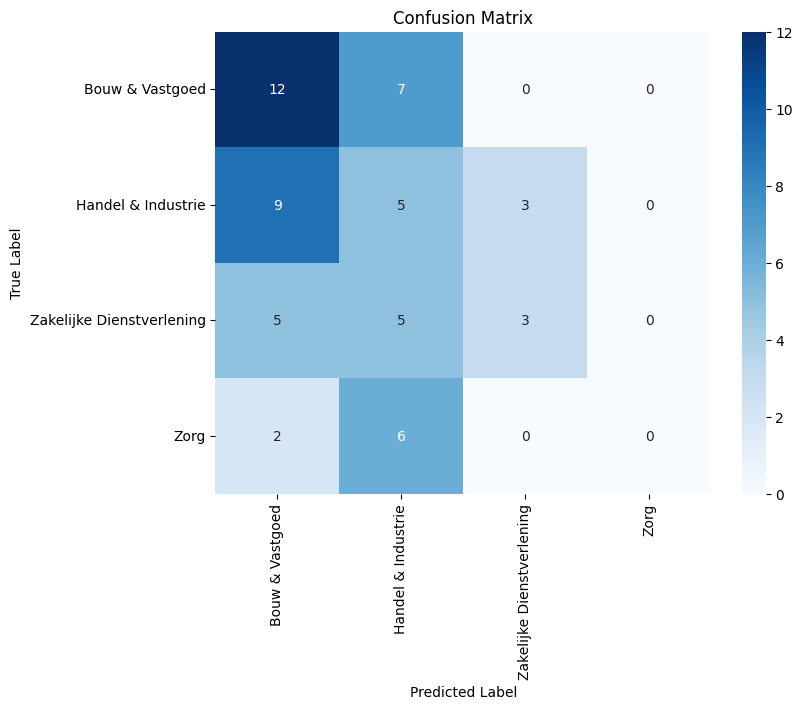

{2: {'accuracy': 0.5109465806862511, 'best_params': {'C': 1, 'kernel': 'rbf'}},
 3: {'accuracy': 0.5171907756813418,
  'best_params': {'C': 10, 'kernel': 'rbf'}},
 5: {'accuracy': 0.5328869047619047,
  'best_params': {'C': 0.1, 'kernel': 'linear'}}}

In [51]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "BoW", model_type = "svm",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "one-hot", ngram_size = 2)


Using ROBBERT Embeddings (pdelobelle/robbert-v2-dutch-base)...


Some weights of RobertaModel were not initialized from the model checkpoint at pdelobelle/robbert-v2-dutch-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Creating robBERT embedding, this may take a few minutes.

Using N-gram POS Features (n=2)...
Best svm Params for k=2: {'C': 1, 'kernel': 'linear'}, Mean Validation Accuracy: 0.6182
Best svm Params for k=3: {'C': 10, 'kernel': 'linear'}, Mean Validation Accuracy: 0.6717
Best svm Params for k=5: {'C': 0.1, 'kernel': 'linear'}, Mean Validation Accuracy: 0.7159

Best model found: 
Model=svm, 
Parameter values: {'C': 0.1, 'kernel': 'linear'}, 
Validation Accuracy: 0.7158730158730158
Final Test Accuracy: 0.6842
Class '0' Accuracy: 0.7368
Class '1' Accuracy: 0.7647
Class '2' Accuracy: 0.4615
Class '3' Accuracy: 0.7500


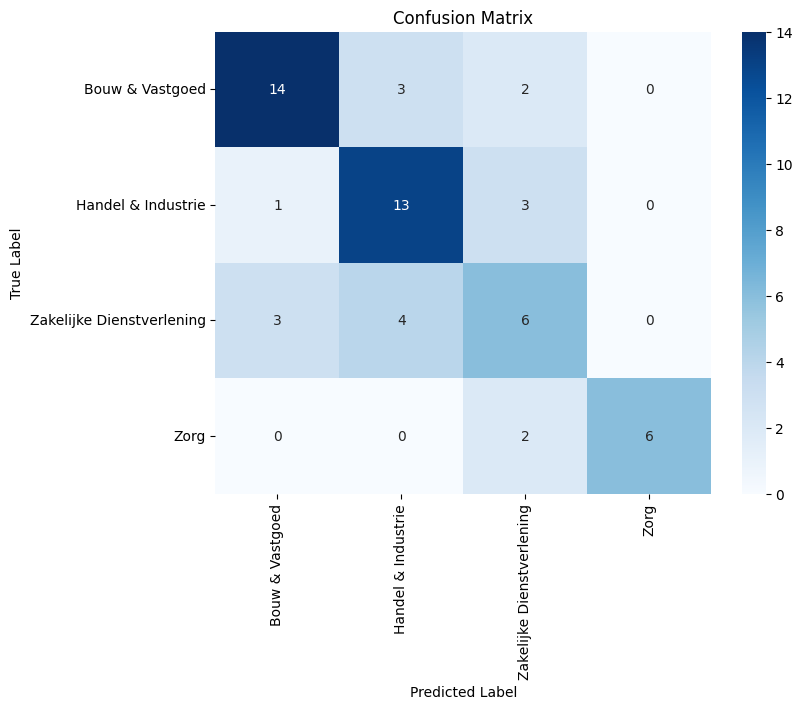

{2: {'accuracy': 0.6182230714115118,
  'best_params': {'C': 1, 'kernel': 'linear'}},
 3: {'accuracy': 0.6716981132075471,
  'best_params': {'C': 10, 'kernel': 'linear'}},
 5: {'accuracy': 0.7158730158730158,
  'best_params': {'C': 0.1, 'kernel': 'linear'}}}

In [52]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "robBERT", model_type = "svm",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "ngram", ngram_size = 2)


Using TF-IDF Embeddings...
Best naive_bayes Params for k=2: {'alpha': 0.01, 'fit_prior': True}, Mean Validation Accuracy: 0.7160
Best naive_bayes Params for k=3: {'alpha': 0.01, 'fit_prior': True}, Mean Validation Accuracy: 0.7317
Best naive_bayes Params for k=5: {'alpha': 0.01, 'fit_prior': True}, Mean Validation Accuracy: 0.7412

Best model found: 
Model=naive_bayes, 
Parameter values: {'alpha': 0.01, 'fit_prior': True}, 
Validation Accuracy: 0.7412202380952382
Final Test Accuracy: 0.5088
Class '0' Accuracy: 0.6842
Class '1' Accuracy: 0.8824
Class '2' Accuracy: 0.0769
Class '3' Accuracy: 0.0000


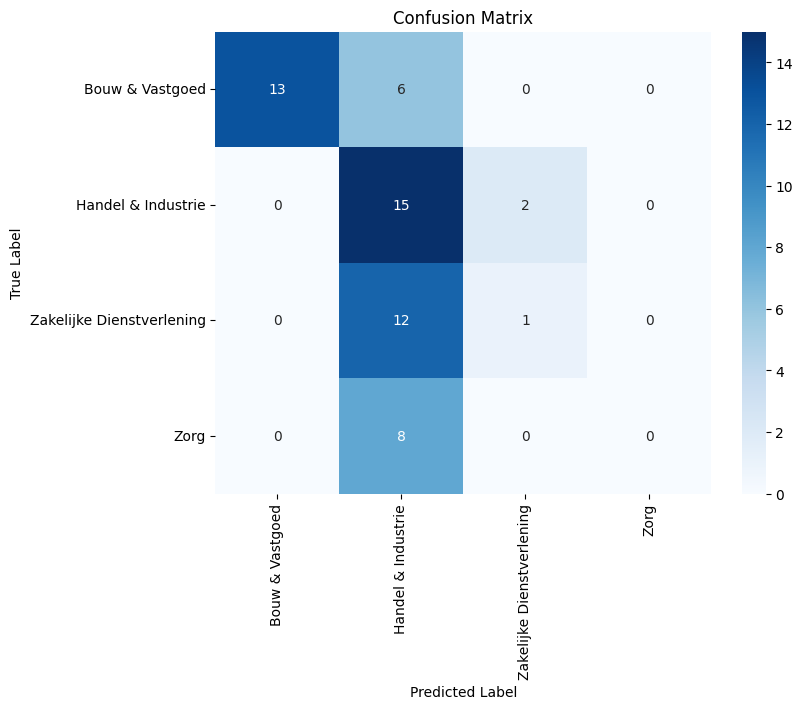

{2: {'accuracy': 0.7160456969986466,
  'best_params': {'alpha': 0.01, 'fit_prior': True}},
 3: {'accuracy': 0.7317160826594789,
  'best_params': {'alpha': 0.01, 'fit_prior': True}},
 5: {'accuracy': 0.7412202380952382,
  'best_params': {'alpha': 0.01, 'fit_prior': True}}}

In [53]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "tf-idf", model_type = "naive_bayes",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "none", ngram_size = 2)


Using TF-IDF Embeddings...
Best naive_bayes Params for k=2: {'alpha': 0.01, 'fit_prior': True}, Mean Validation Accuracy: 0.7160
Best naive_bayes Params for k=3: {'alpha': 0.01, 'fit_prior': True}, Mean Validation Accuracy: 0.7317
Best naive_bayes Params for k=5: {'alpha': 0.01, 'fit_prior': True}, Mean Validation Accuracy: 0.7412

Best model found: 
Model=naive_bayes, 
Parameter values: {'alpha': 0.01, 'fit_prior': True}, 
Validation Accuracy: 0.7412202380952382
Final Test Accuracy: 0.5088
Class '0' Accuracy: 0.6842
Class '1' Accuracy: 0.8824
Class '2' Accuracy: 0.0769
Class '3' Accuracy: 0.0000


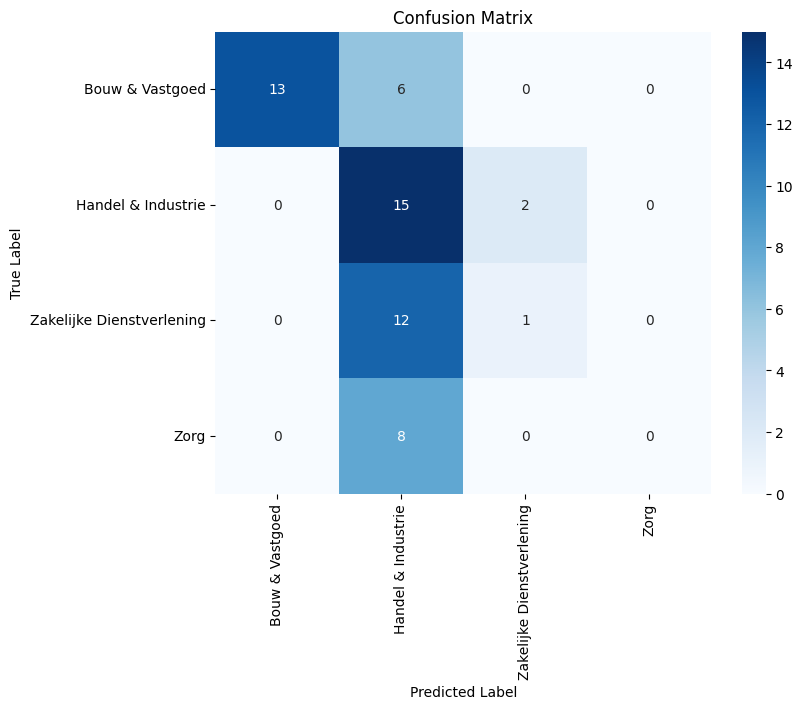

{2: {'accuracy': 0.7160456969986466,
  'best_params': {'alpha': 0.01, 'fit_prior': True}},
 3: {'accuracy': 0.7317160826594789,
  'best_params': {'alpha': 0.01, 'fit_prior': True}},
 5: {'accuracy': 0.7412202380952382,
  'best_params': {'alpha': 0.01, 'fit_prior': True}}}

In [54]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "tf-idf", model_type = "naive_bayes",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "none", ngram_size = 2)


Using Bag of Words (BoW) Embeddings...

Using N-gram POS Features (n=2)...
Best naive_bayes Params for k=2: {'var_smoothing': 1e-11}, Mean Validation Accuracy: 0.6845
Best naive_bayes Params for k=3: {'var_smoothing': 1e-11}, Mean Validation Accuracy: 0.6907
Best naive_bayes Params for k=5: {'var_smoothing': 1e-07}, Mean Validation Accuracy: 0.6940

Best model found: 
Model=naive_bayes, 
Parameter values: {'var_smoothing': 1e-07}, 
Validation Accuracy: 0.694047619047619
Final Test Accuracy: 0.7544
Class '0' Accuracy: 0.8421
Class '1' Accuracy: 0.8235
Class '2' Accuracy: 0.6154
Class '3' Accuracy: 0.6250


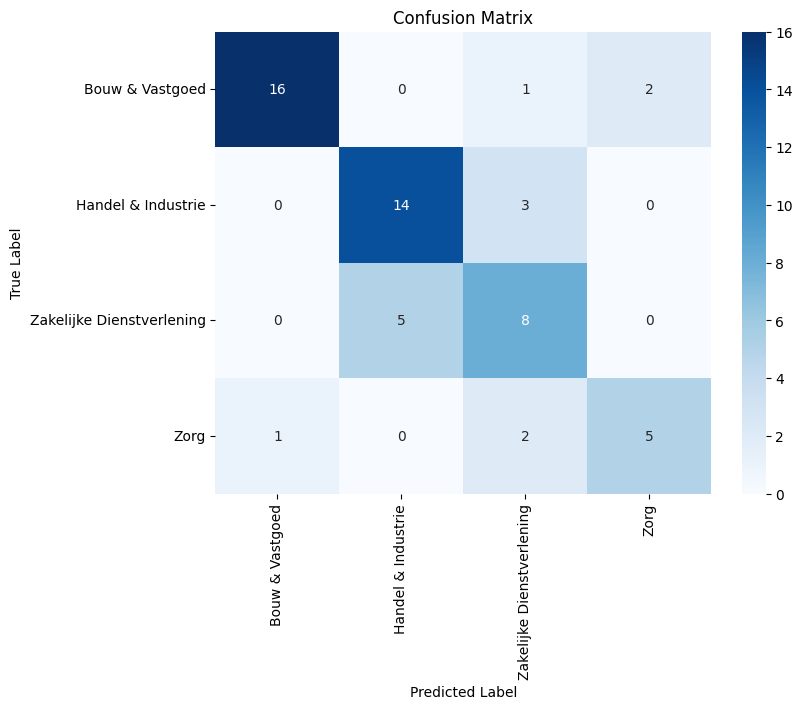

{2: {'accuracy': 0.6844598360003185, 'best_params': {'var_smoothing': 1e-11}},
 3: {'accuracy': 0.6906858340820605, 'best_params': {'var_smoothing': 1e-11}},
 5: {'accuracy': 0.694047619047619, 'best_params': {'var_smoothing': 1e-07}}}

In [57]:
evaluate_model(df, test_ratio = 0.15, k_values = [2, 3, 5], 
                   embedding = "BoW", model_type = "naive_bayes",
                   C_values = [0.1, 1, 10], kernel_values = ['linear', 'rbf', 'poly'],
                   max_depth_values = [5, 10, 15, 20, None],
                   alpha_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                   fit_prior_values = [True, False],
                   var_smoothing_values = [10**-11, 10**-10, 10**-9, 10**-8, 10**-7],
                   pos = "ngram", ngram_size = 2)

In [ ]:
# To Do:

# -Add some print statements to show the model chosen en parameters, especially for Gaussian- of Multinomial Naive Bayes
# -Print update of best model after every k
# -Clean Code and add/remove/update comments where needed
# -Return actual model and validation accuracy such that we can visualize the results in confusion matrices
# -If 2 classes too close in likelihood or no class likelihood exceeds threshold, then say class 5

# Finding the best model

Our goal is to find the classifier with the highest validation accuracy for each model type

In [63]:
# Random Forest

counter = 0
n_values = [2,3,5]
val_accuracies = []

# Global variables to track the best model across all iterations
best_overall_model = None
best_overall_accuracy = float('-inf')  # Initialize with negative infinity
best_overall_params = None

# For tracking progress
total_combinations = len(["BoW", "tf-idf", "BERTje", "mBERT", "RobBERT", "Word2Vec"]) * len(["none", "one-hot"] + 3*["ngram"])

for embedding in ["BoW", "tf-idf", "BERTje", "mBERT", "RobBERT", "Word2Vec"]:
    for pos in ["none", "one-hot"] + 3*["ngram"]:
        
        n = 2 # Default value in case pos != "ngram"
        if pos == "ngram":
            n = n_values[counter % 3]
            counter += 1
        
        results = evaluate_model(df, 
                                 test_ratio = 0.15, 
                                 k_values = [1,2,3,5,10,20],
                                 embedding = embedding, 
                                 model_type = "random_forest",
                                 pos = pos, 
                                 ngram_size = n,
                                 print_updates = False,
                                 show_class_accuracy = False, 
                                 show_confusion_matrix = False)

        # Find the best model in this iteration
        best_model = max(results.items(), key=lambda x: x[1]['accuracy'])
        best_model_key = best_model[0]
        best_accuracy = best_model[1]['accuracy']
        best_params = best_model[1]['best_params']

        # Update global best if the current model is better
        if best_accuracy > best_overall_accuracy:
            best_overall_accuracy = best_accuracy
            best_overall_model = (embedding, pos, best_model_key)  # Store relevant info
            best_overall_params = best_params

# Print the overall best model after all iterations
print(f"Best overall model: {best_overall_model}")
print(f"Best overall accuracy: {best_overall_accuracy}")
print(f"Best overall parameters: {best_overall_params}")

In [ ]:
# Random Forest

counter = 0
n_values = [2, 3, 5]

# Total iterations to track progress
total_combinations = len(["BoW", "tf-idf", "BERTje", "mBERT", "RobBERT", "Word2Vec"]) * len(["none", "one-hot"] + 3 * ["ngram"])

# Initialize tracking variables
best_overall_model = None
best_overall_accuracy = float('-inf')
best_overall_params = None

# Create tqdm progress bar
with tqdm(total=total_combinations, desc="Progress", unit="iteration") as pbar:
    for embedding in ["BoW", "tf-idf", "BERTje", "mBERT", "RobBERT", "Word2Vec"]:
        for pos in ["none", "one-hot"] + 3 * ["ngram"]:
            
            n = 2  # Default value in case pos != "ngram"
            if pos == "ngram":
                n = n_values[counter % 3]
                counter += 1
            
            results = evaluate_model(df, 
                                     test_ratio=0.15, 
                                     k_values=[1, 2, 3, 5, 10, 20],
                                     embedding=embedding, 
                                     model_type="random_forest",
                                     pos=pos, 
                                     ngram_size=n,
                                     print_updates=False,
                                     show_class_accuracy=False, 
                                     show_confusion_matrix=False)

            # Find the best model in this iteration
            best_model = max(results.items(), key=lambda x: x[1]['accuracy'])
            best_model_key = best_model[0]
            best_accuracy = best_model[1]['accuracy']
            best_params = best_model[1]['best_params']

            # Update global best if the current model is better
            if best_accuracy > best_overall_accuracy:
                best_overall_accuracy = best_accuracy
                best_overall_model = (embedding, pos, best_model_key)
                best_overall_params = best_params

            # Update the progress bar
            pbar.update(1)

# Print the overall best model after all iterations
print(f"Best overall model: {best_overall_model}")
print(f"Best overall accuracy: {best_overall_accuracy}")
print(f"Best overall parameters: {best_overall_params}")

Progress:   0%|                                                                          | 0/30 [00:00<?, ?iteration/s]

In [ ]:
# Support Vector Machine

counter = 0
n_values = [2, 3, 5]

# Total iterations to track progress
total_combinations = len(["BoW", "tf-idf", "BERTje", "mBERT", "RobBERT", "Word2Vec"]) * len(["none", "one-hot"] + 3 * ["ngram"])

# Initialize tracking variables
best_overall_model = None
best_overall_accuracy = float('-inf')
best_overall_params = None

# Create tqdm progress bar
with tqdm(total=total_combinations, desc="Progress", unit="iteration") as pbar:
    for embedding in ["BoW", "tf-idf", "BERTje", "mBERT", "RobBERT", "Word2Vec"]:
        for pos in ["none", "one-hot"] + 3 * ["ngram"]:
            
            n = 2  # Default value in case pos != "ngram"
            if pos == "ngram":
                n = n_values[counter % 3]
                counter += 1
            
            results = evaluate_model(df, 
                                     test_ratio=0.15, 
                                     k_values=[1, 2, 3, 5, 10, 20],
                                     embedding=embedding, 
                                     model_type="svm",
                                     pos=pos, 
                                     ngram_size=n,
                                     print_updates=False,
                                     show_class_accuracy=False, 
                                     show_confusion_matrix=False)

            # Find the best model in this iteration
            best_model = max(results.items(), key=lambda x: x[1]['accuracy'])
            best_model_key = best_model[0]
            best_accuracy = best_model[1]['accuracy']
            best_params = best_model[1]['best_params']

            # Update global best if the current model is better
            if best_accuracy > best_overall_accuracy:
                best_overall_accuracy = best_accuracy
                best_overall_model = (embedding, pos, best_model_key)
                best_overall_params = best_params

            # Update the progress bar
            pbar.update(1)

# Print the overall best model after all iterations
print(f"Best overall model: {best_overall_model}")
print(f"Best overall accuracy: {best_overall_accuracy}")
print(f"Best overall parameters: {best_overall_params}")

In [ ]:
# Naive Bayes

counter = 0
n_values = [2, 3, 5]

# Total iterations to track progress
total_combinations = len(["BoW", "tf-idf", "BERTje", "mBERT", "RobBERT", "Word2Vec"]) * len(["none", "one-hot"] + 3 * ["ngram"])

# Initialize tracking variables
best_overall_model = None
best_overall_accuracy = float('-inf')
best_overall_params = None

# Create tqdm progress bar
with tqdm(total=total_combinations, desc="Progress", unit="iteration") as pbar:
    for embedding in ["BoW", "tf-idf", "BERTje", "mBERT", "RobBERT", "Word2Vec"]:
        for pos in ["none", "one-hot"] + 3 * ["ngram"]:
            
            n = 2  # Default value in case pos != "ngram"
            if pos == "ngram":
                n = n_values[counter % 3]
                counter += 1
            
            results = evaluate_model(df, 
                                     test_ratio=0.15, 
                                     k_values=[1, 2, 3, 5, 10, 20],
                                     embedding=embedding, 
                                     model_type="naive_bayes",
                                     pos=pos, 
                                     ngram_size=n,
                                     print_updates=False,
                                     show_class_accuracy=False, 
                                     show_confusion_matrix=False)

            # Find the best model in this iteration
            best_model = max(results.items(), key=lambda x: x[1]['accuracy'])
            best_model_key = best_model[0]
            best_accuracy = best_model[1]['accuracy']
            best_params = best_model[1]['best_params']

            # Update global best if the current model is better
            if best_accuracy > best_overall_accuracy:
                best_overall_accuracy = best_accuracy
                best_overall_model = (embedding, pos, best_model_key)
                best_overall_params = best_params

            # Update the progress bar
            pbar.update(1)

# Print the overall best model after all iterations
print(f"Best overall model: {best_overall_model}")
print(f"Best overall accuracy: {best_overall_accuracy}")
print(f"Best overall parameters: {best_overall_params}")

# Small test on 2 articles

This section aims to test the obtained classifier for 2 articles. To achieve this, we first load the data

In [21]:
def extract_text_from_pdf(pdf_path):
    document = fitz.open(pdf_path)
    text = ""
    for page_num in range(len(document)):
        page = document.load_page(page_num)
        text += page.get_text()
    return text

directory = 'small experiment for presentation'
df_experiment = pd.DataFrame(columns=['article_id' , 'paragraph_id', 'text', 'group', 'publication_date'])

print('Please ensure that only pdf files of articles are present in the subfolders of the specified directory')
article_nr = 1
for folder in os.listdir(directory):
    folder_size = len(os.listdir(directory + "\\" + folder))
    print(f'{folder_size} article(s) detected in {folder} folder')
    
    for article in os.listdir(directory + '\\' + folder):
        text = extract_text_from_pdf(directory + '\\' + folder + '\\' + article)
        date = article.split(' ')[-1].split('.')[0] #Remove the article number and ".pdf" to obtain the publication date
        
        paragraphs = [para.strip() for para in text.split("\n \n") if para.strip()]
        para_nr = 1
        for para in paragraphs:
            df_temp = pd.DataFrame([[article_nr, para_nr, para, folder, date]], 
                                   columns=['article_id' , 'paragraph_id', 'text', 'group', 'publication_date'])
            df_experiment = pd.concat([df_experiment, df_temp])
            para_nr += 1
        article_nr += 1
        
df_experiment.set_index(['article_id' , 'paragraph_id'], inplace=True)
df_experiment['publication_date'] = pd.to_datetime(df_experiment['publication_date'], format='%d-%m-%Y')

Please ensure that only pdf files of articles are present in the subfolders of the specified directory
1 article(s) detected in Bouw & Vastgoed folder
0 article(s) detected in Handel & Industrie folder
1 article(s) detected in Zakelijke Dienstverlening folder
0 article(s) detected in Zorg folder


In [22]:
df_experiment

text  \
article_id paragraph_id                                                      
1          1             Huizen 12% duurder in november, grootste stijg...   
           2             Na jarenlange dalingen van de huizenprijzen be...   
           3             In november wisselden 17.973 woningen van eige...   
           4             Gecorrigeerd voor inflatie zijn de huizenprijz...   
2          1             Accountants Deloitte overtraden beroepsregels ...   
           2             ‘Passende maatregelen’ \n‘Ons interne onderzoe...   
           3             Scholen vinden lastig een accountant \nDe onde...   

                                             group publication_date  
article_id paragraph_id                                              
1          1                       Bouw & Vastgoed       2024-12-23  
           2                       Bouw & Vastgoed       2024-12-23  
           3                       Bouw & Vastgoed       2024-12-23  
           4                       Bouw & Vastgoed       2024-12-23  
2          1             Zakelijke Dienstverlening       2025-01-06  
           2             Zakelijke Dienstverlening       2025-01-06  
           3             Zakelijke Dienstverlening       2025-01-06